In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F

In [4]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.utils.data

In [5]:
#transform
data_transforms = transforms.Compose([
        transforms.ToTensor(),
        lambda x: x>0.5,
        lambda x: x.float(),
    ])

In [6]:
# dataset loading
bsize = 100
train_loader = torch.utils.data.DataLoader(
    dset.MNIST('data', train=True, download=True, transform=data_transforms), batch_size=bsize, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dset.MNIST('data', train=False, download=True, transform=data_transforms), batch_size=bsize, shuffle=True)

In [7]:
# hyperparameters
N = 4
k = 2
tau = 1.

In [8]:
# gumbel-softmax
def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    return -Variable(torch.log(-torch.log(U + eps) + eps))

def gumbel_softmax_sample(logits, temperature):
    y = logits + sample_gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)

def gumbel_softmax(logits, temperature):
    """
    input: [*, n_class]
    return: [*, n_class] an one-hot vector
    """
    y = gumbel_softmax_sample(logits, temperature)
    shape = y.size()
    _, ind = y.max(dim=-1)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    return (y_hard - y).detach() + y

In [9]:
class encoder(nn.Module):
    def __init__(self):
        super(encoder, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 128)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        l = self.relu(self.fc2(h1))
        return l

In [10]:
class tunnel_1(nn.Module):
    def __init__(self):
        super(tunnel_1, self).__init__()
        self.fc1 = nn.Linear(128, 128)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        l = self.relu(self.fc1(x))
        return l
    
class tunnel_2(nn.Module):
    def __init__(self):
        super(tunnel_2, self).__init__()
        self.fc1 = nn.Linear(128, 128)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        l = self.relu(self.fc1(x))
        return l

class tunnel_3(nn.Module):
    def __init__(self):
        super(tunnel_3, self).__init__()
        self.fc1 = nn.Linear(128, 128)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        l = self.relu(self.fc1(x))
        return l

In [11]:
class output_0(nn.Module):
    def __init__(self):
        super(output_0, self).__init__()
        self.fc1 = nn.Linear(128, 2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        l = h1.view(-1,2)
        return l
    
class output_1(nn.Module):
    def __init__(self):
        super(output_1, self).__init__()
        self.fc1 = nn.Linear(128, 2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        l = h1.view(-1,2)
        return l

class output_2(nn.Module):
    def __init__(self):
        super(output_2, self).__init__()
        self.fc1 = nn.Linear(128, 2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        l = h1.view(-1,2)
        return l
    
class output_3(nn.Module):
    def __init__(self):
        super(output_3, self).__init__()
        self.fc1 = nn.Linear(128, 2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        l = h1.view(-1,2)
        return l

In [12]:
def prob(l0, l1, l2, l3):
    return torch.cat((F.softmax(l0, dim=-1),
                      F.softmax(l1, dim=-1),
                      F.softmax(l2, dim=-1),
                      F.softmax(l3, dim=-1)),dim=1).view(-1, N, k)

def sample(l):
    return gumbel_softmax(l, tau)

def signal(l0, l1, l2, l3):
    return torch.cat((sample(l0).narrow(1,0,1),
                       sample(l1).narrow(1,0,1),
                       sample(l2).narrow(1,0,1),
                       sample(l3).narrow(1,0,1)),
                      dim=1)
    

In [21]:
class decoder(nn.Module):  
    def __init__(self):
        super(decoder, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)      
        self.fc4 = nn.Linear(512, 784)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        h3 = self.relu(self.fc3(h2))
        h4 = self.fc4(h3)
        o = h4.view(-1,784)
        return F.sigmoid(o)

In [22]:
E = encoder()
D = decoder()
T1 = tunnel_1()
T2 = tunnel_2()
T3 = tunnel_3()
O0 = output_0()
O1 = output_1()
O2 = output_2()
O3 = output_3()

In [23]:
# objective
def loss_function(recon_x, x, q):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    
    KLD = torch.sum(q*(torch.log(q+1E-20)-np.log(1/k)))

    return BCE + KLD

In [24]:
# training
epochs = 25
optimizer = optim.Adam([
                {'params':E.parameters()},
                {'params':D.parameters()},
                {'params':T1.parameters()},
                {'params':T2.parameters()},
                {'params':T3.parameters()},
                {'params':O0.parameters()},
                {'params':O1.parameters()},
                {'params':O2.parameters()},
                {'params':O3.parameters()},
            ], lr=1e-4)

train_loss = 0
for epoch in range(epochs):
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        x = data.view(-1,784)
        optimizer.zero_grad()
        c0 = E.forward(x)
        l0 = O0.forward(c0)
        c1 = T1.forward(c0)
        l1 = O1.forward(c1)
        c2 = T2.forward(c1)
        l2 = O2.forward(c2)
        c3 = T3.forward(c2)
        l3 = O3.forward(c3)
        bits = signal(l0,l1,l2,l3)
        q = prob(l0,l1,l2,l3)
        recon_x = D.forward(bits)
        loss = loss_function(recon_x, x, q)
        loss.backward()
        train_loss += loss.data[0]
        optimizer.step()
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data[0] / len(data)))
            

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch+1, train_loss / len(train_loader.dataset)))

    


Train Epoch: 1 [0/60000 (0%)]	Loss: 544.364023
Train Epoch: 1 [20000/60000 (33%)]	Loss: 208.185625
Train Epoch: 1 [40000/60000 (67%)]	Loss: 203.416602
====> Epoch: 1 Average loss: 236.6819
Train Epoch: 2 [0/60000 (0%)]	Loss: 207.584355
Train Epoch: 2 [20000/60000 (33%)]	Loss: 209.847832
Train Epoch: 2 [40000/60000 (67%)]	Loss: 206.333945
====> Epoch: 2 Average loss: 445.0552
Train Epoch: 3 [0/60000 (0%)]	Loss: 206.723184
Train Epoch: 3 [20000/60000 (33%)]	Loss: 210.192793
Train Epoch: 3 [40000/60000 (67%)]	Loss: 208.728711
====> Epoch: 3 Average loss: 653.4012
Train Epoch: 4 [0/60000 (0%)]	Loss: 203.685605
Train Epoch: 4 [20000/60000 (33%)]	Loss: 202.862734
Train Epoch: 4 [40000/60000 (67%)]	Loss: 212.304531
====> Epoch: 4 Average loss: 861.7376
Train Epoch: 5 [0/60000 (0%)]	Loss: 211.958965
Train Epoch: 5 [20000/60000 (33%)]	Loss: 203.656523
Train Epoch: 5 [40000/60000 (67%)]	Loss: 191.485918
====> Epoch: 5 Average loss: 1065.0054
Train Epoch: 6 [0/60000 (0%)]	Loss: 188.225254
Train E

KeyboardInterrupt: 

In [25]:
q

Variable containing:
( 0 ,.,.) = 
  9.9973e-01  2.6704e-04
  1.0000e+00  9.7597e-08
  1.0000e+00  2.5432e-09
  5.0000e-01  5.0000e-01

( 1 ,.,.) = 
  5.5439e-01  4.4561e-01
  1.0000e+00  9.3353e-09
  1.0000e+00  2.3040e-10
  5.0000e-01  5.0000e-01

( 2 ,.,.) = 
  9.9967e-01  3.3092e-04
  1.0000e+00  1.2955e-06
  1.0000e+00  4.6848e-08
  5.0000e-01  5.0000e-01

( 3 ,.,.) = 
  9.9998e-01  1.6192e-05
  5.0000e-01  5.0000e-01
  5.0000e-01  5.0000e-01
  5.0000e-01  5.0000e-01

( 4 ,.,.) = 
  7.3737e-04  9.9926e-01
  5.0000e-01  5.0000e-01
  6.3896e-01  3.6104e-01
  5.1400e-11  1.0000e+00

( 5 ,.,.) = 
  1.5823e-04  9.9984e-01
  9.9910e-01  8.9627e-04
  9.9578e-01  4.2178e-03
  5.0000e-01  5.0000e-01

( 6 ,.,.) = 
  9.9999e-01  5.1097e-06
  1.0000e+00  3.5373e-09
  1.0000e+00  6.6211e-11
  5.0000e-01  5.0000e-01

( 7 ,.,.) = 
  9.9969e-01  3.1486e-04
  9.9997e-01  3.2194e-05
  1.0000e+00  4.7103e-06
  5.0000e-01  5.0000e-01

( 8 ,.,.) = 
  3.5798e-03  9.9642e-01
  5.0000e-01  5.0000e-01
  5.

In [26]:
bits

Variable containing:
    1     1     1     0
    0     1     1     0
    1     1     1     1
    1     1     0     0
    0     0     1     0
    0     1     1     0
    1     1     1     0
    1     1     1     0
    0     1     0     0
    1     1     1     0
    1     1     0     0
    1     1     1     0
    0     1     1     0
    0     1     1     0
    1     1     0     0
    1     0     0     1
    1     1     0     0
    1     1     1     1
    0     1     1     0
    1     1     0     1
    1     1     1     1
    0     0     0     1
    1     1     1     1
    1     1     1     0
    0     1     1     0
    1     1     1     0
    0     1     1     0
    1     0     0     0
    1     1     1     0
    1     1     1     0
    1     1     1     1
    0     1     1     0
    0     1     1     0
    0     0     0     1
    0     1     1     0
    0     1     1     0
    1     1     1     1
    1     0     1     0
    0     1     1     1
    0     1     1     1
    0     1     1  

In [27]:
test_set = dset.MNIST('data', train=False, download=True, transform=data_transforms)

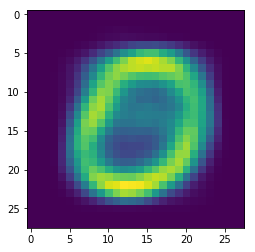

In [47]:
a = np.array([[0., 0., 0., 0.]])
w = D.forward(Variable(torch.from_numpy(a).type(torch.FloatTensor)))
plt.imshow(w.view(28,28).data.numpy())

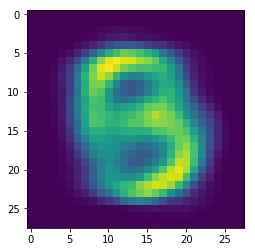

In [29]:
a = np.array([[0., 0., 0., 1.]])
w = D.forward(Variable(torch.from_numpy(a).type(torch.FloatTensor)))
plt.imshow(w.view(28,28).data.numpy())

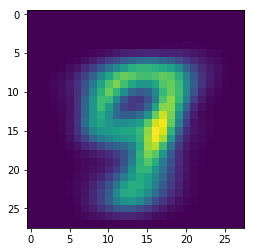

In [59]:
a = np.array([[1., 1., 0., 0.]])
w = D.forward(Variable(torch.from_numpy(a).type(torch.FloatTensor)))
plt.imshow(w.view(28,28).data.numpy())

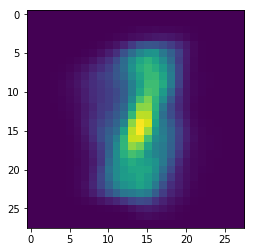

In [63]:
a = np.array([[1., 1., 1., 1.]])
w = D.forward(Variable(torch.from_numpy(a).type(torch.FloatTensor)))
plt.imshow(w.view(28,28).data.numpy())

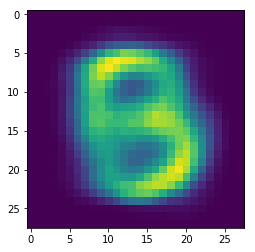

In [31]:
a = np.array([[0., 0., 1., 1.]])
w = D.forward(Variable(torch.from_numpy(a).type(torch.FloatTensor)))
plt.imshow(w.view(28,28).data.numpy())

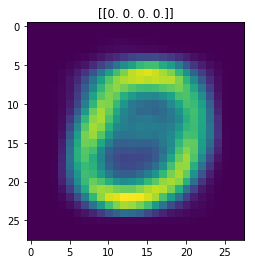

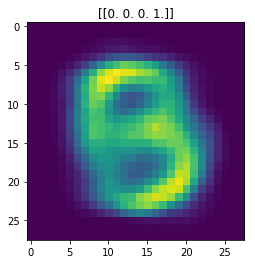

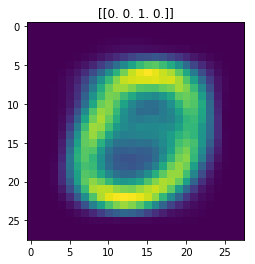

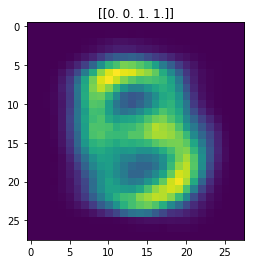

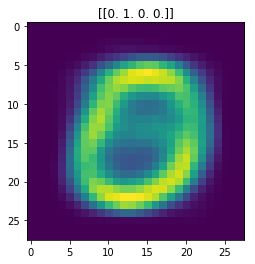

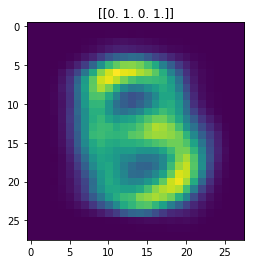

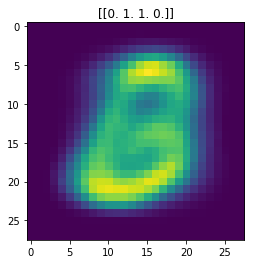

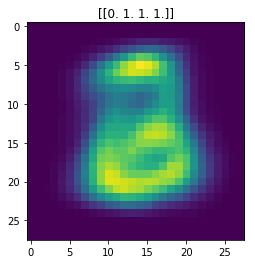

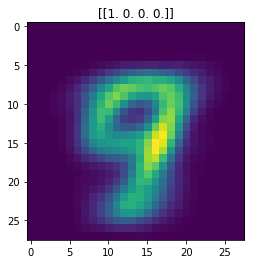

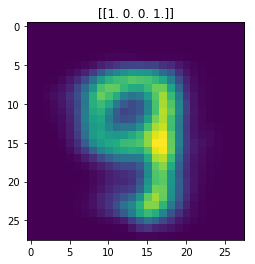

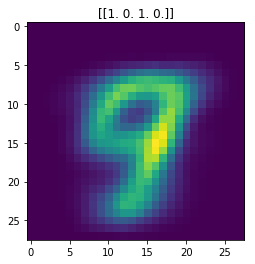

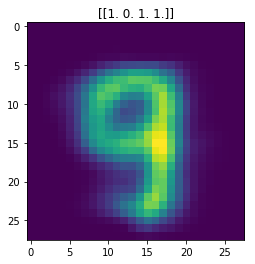

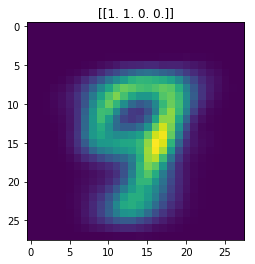

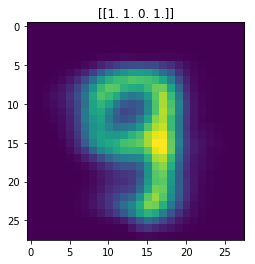

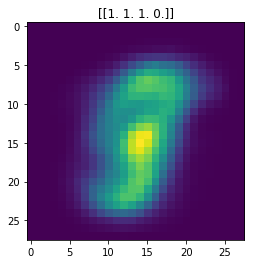

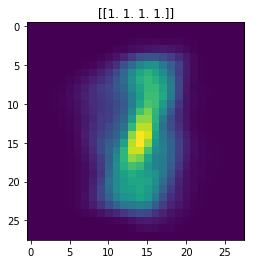

In [69]:
#plt.figure()
k = 1
for i1 in range(2):
    for i2 in range(2):
        for i3 in range(2):
            for i4 in range(2):
                a = np.array([[float(i1), float(i2), float(i3), float(i4)]])
                w = D.forward(Variable(torch.from_numpy(a).type(torch.FloatTensor)))
                #plt.subplot(1, 16, k)
                plt.title(a)
                plt.imshow(w.view(28,28).data.numpy())
                k += 1
                plt.show()


In [ ]:
    for i in range(len(actor_code)):
        one_hot = np.zeros(len(actor_code))
        one_hot[i] = 1
        plt.subplot(1, 11, i+2)
        plt.axis('off')
        plt.title(actor_code[i] + '\n' + str(probabilities[i]), fontsize=14)
        saliency = guided_backprop(graph, image, one_hot, sess)
        saliency_diff = true_saliency - saliency
        saliency_diff = (saliency_diff * (saliency_diff>0))
        scaling_adjustment = 1E-20
        saliency_diff = saliency_diff/(np.max(saliency_diff)+scaling_adjustment)
        plt.imshow(saliency_diff)